In [10]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

from ipynb.fs.full.SeedFinder import all_seeds

In [11]:
def display_seed(seed):
    plt.imshow(seed, cmap='gray')
    plt.title(f'seed')
    plt.colorbar()
    plt.show()

Find the seed in the image using Opencv and Scipy.

In [12]:
def find_seed_contour(seed, threshold=400):
    normalized_image = cv2.normalize(seed.copy(), None, 0, 255, cv2.NORM_MINMAX)
    image_uint8 = normalized_image.astype(np.uint8)

    _, binary_image = cv2.threshold(image_uint8, int(threshold * 255 / 4096), 255, cv2.THRESH_BINARY)

    contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return max(contours, key=cv2.contourArea)

In [13]:
def extract_width_height_from_contour(contour):
    rightmost_point = max(contour, key=lambda point: point[0][0])  # Max x-coordinate
    leftmost_point = min(contour, key=lambda point: point[0][0])  # Min x-coordinate
    uppermost_point = min(contour, key=lambda point: point[0][1])  # Min y-coordinate
    downmost_point = max(contour, key=lambda point: point[0][1])  # Max y-coordinate
    y_uppermost, x_leftmost = uppermost_point[0][1] - 1, leftmost_point[0][0] - 1
    y_downmost, x_rightmost = downmost_point[0][1] + 1, rightmost_point[0][0] + 1
    return x_rightmost - x_leftmost + 1, y_downmost - y_uppermost + 1, x_leftmost, y_uppermost

In [14]:
def find_seed_width_height_area(seed):
    seed_contour = find_seed_contour(seed)
    area = cv2.contourArea(seed_contour)
    return *extract_width_height_from_contour(seed_contour), area

In [15]:
from scipy.spatial import Delaunay

def find_seed_mask(seed):
    contour = find_seed_contour(seed)
    width, height, x_start, y_start, _ = find_seed_width_height_area(seed)
    points = contour.reshape(-1, 2)
    tri = Delaunay(points)
    mask = np.zeros(seed.shape, dtype=np.uint8)
    for simplex in tri.simplices:
        triangle = points[simplex]
        cv2.fillConvexPoly(mask, triangle, 255)
    cv2.drawContours(mask, contour, -1, (255), thickness=cv2.FILLED)
    mask = mask[y_start:y_start+height, x_start:x_start+width]
    return mask, y_start, x_start, height, width

This function gets a hyperspectral 3d image of a seed and a representative band and returns a new image where all the nonseed pixels are zeroed across all the bands.

In [16]:
def get_seed_masked_image(hyperspectral_seed, band_number):
    band_image = hyperspectral_seed[:,:,band_number]
    mask, y_start, x_start, height, width = find_seed_mask(band_image)
    full_mask = np.zeros_like(band_image, dtype=np.uint8)
    full_mask[y_start:y_start + height, x_start:x_start + width] = mask
    full_mask_expanded = (full_mask / 255)[:, :, None]
    masked_hsi = hyperspectral_seed * full_mask_expanded
    return masked_hsi[y_start:y_start + height, x_start:x_start + width].astype(hyperspectral_seed.dtype)

This function gets a seed and returns the seed pixels, their indices, and the shape.

In [17]:
def extract_seed_pixels(seed, start_band=100, end_band=740):
    _, y_start, x_start, height, width = find_seed_mask(seed[:,:,200])
    seed_mask_all_bands = seed[y_start:y_start+height,x_start:x_start+width,start_band:end_band]
    # TODO add choice to find all the nonzero spatial pixels in the middle band or all bands because the middle band has more pixels and all bands has less noise
    seed_pixels_200 = np.argwhere(seed_mask_all_bands[:,:,200])
    return seed_mask_all_bands[seed_pixels_200[:, 0], seed_pixels_200[:, 1], :], seed_pixels_200, seed_mask_all_bands.shape

In this example I get a new image where nonseed pixels are zeroed based on band 200. The I show the original 2d band 200, the 2d mask, and band 600 (randomly chosen) in the new image.

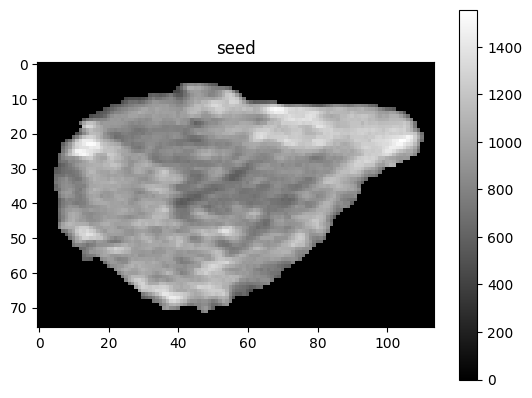

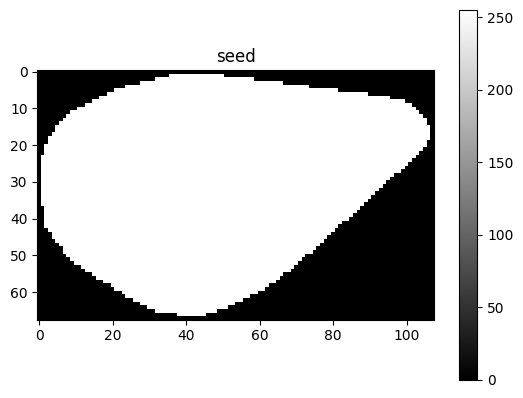

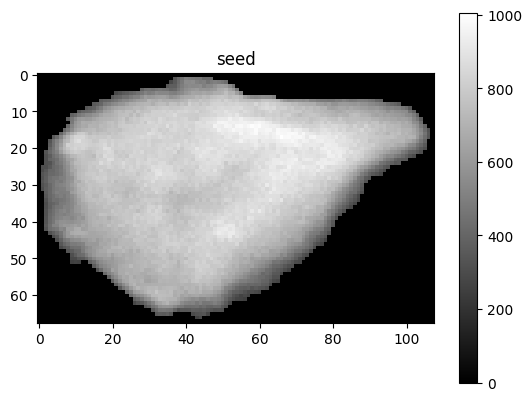

In [18]:
seed = np.load(all_seeds[11])
mask, y_start, x_start, height, width = find_seed_mask(seed[:,:,200])
masked_image = get_seed_masked_image(seed, 200)

display_seed(seed[:,:,200])
display_seed(mask)
display_seed(masked_image[:,:,600])